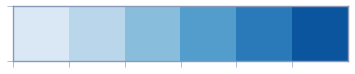

In [11]:
from sklearn.mixture import GaussianMixture
import numpy as np
from scipy.stats import multivariate_normal, mode, norm
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, completeness_score, homogeneity_score, confusion_matrix, confusion_matrix, classification_report
import seaborn as sns
sns.palplot(sns.color_palette("Blues"))
import pandas as pd

In [12]:
import data

x_train, x_test, y_train, y_test = data.load_sk_digits()


In [13]:
x_train = x_train / 16
x_test = x_test / 16

array([[14.80078125,  8.6796875 , 11.65234375, ..., 11.0390625 ,
        13.6484375 , 11.8515625 ],
       [ 8.6796875 , 12.83984375, 10.30859375, ...,  9.36328125,
         9.22265625,  8.265625  ],
       [11.65234375, 10.30859375, 16.35546875, ..., 10.9296875 ,
        10.921875  , 10.328125  ],
       ...,
       [11.0390625 ,  9.36328125, 10.9296875 , ..., 13.61328125,
        12.515625  ,  9.97265625],
       [13.6484375 ,  9.22265625, 10.921875  , ..., 12.515625  ,
        21.8125    , 11.34375   ],
       [11.8515625 ,  8.265625  , 10.328125  , ...,  9.97265625,
        11.34375   , 14.4453125 ]])

0
delta mean inf
delta cov inf


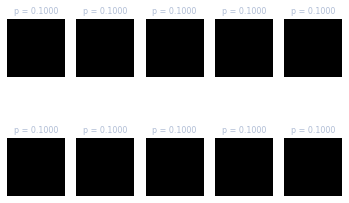

10
delta mean 0.01813059199353434
delta cov 0.007316503179054079


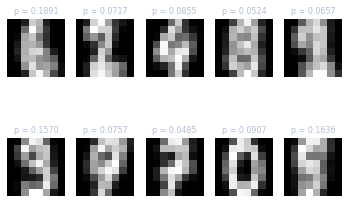

20
delta mean 0.006236243141192643
delta cov 0.0028545300346213


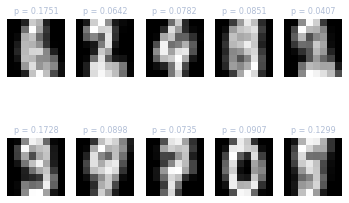

30
delta mean 0.000173880140342364
delta cov 9.107385906115262e-05


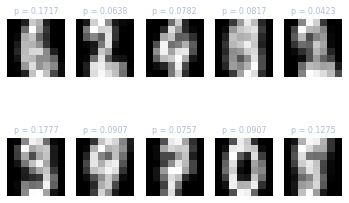

40
delta mean 0.0005220536680210497
delta cov 0.00016414816750812133


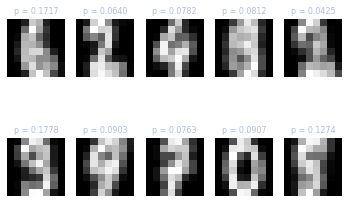

50
delta mean 0.00232245127931352
delta cov 0.0009401255253235763


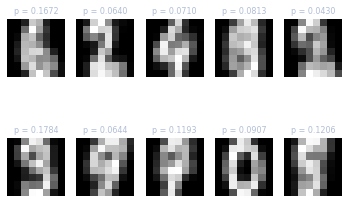

60
delta mean 4.6482859721086456e-05
delta cov 2.8668400667064553e-05


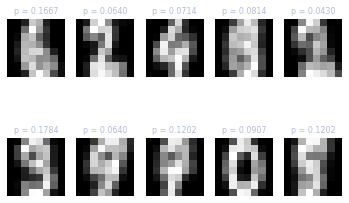

70
delta mean 2.2517713862080235e-05
delta cov 1.401734248862585e-05


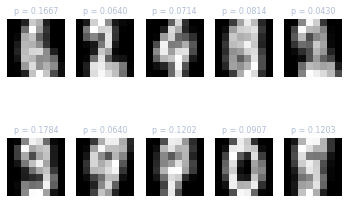

80
delta mean 2.3274421701025005e-05
delta cov 1.449647847295843e-05


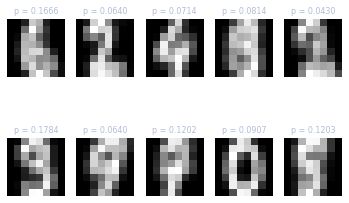

90
delta mean 4.266381881767867e-05
delta cov 2.6687634516742165e-05


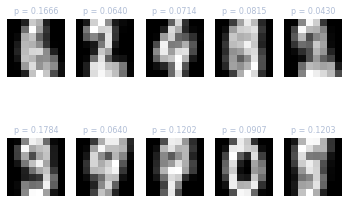

In [26]:
class GMM:
    def __init__(self, k, tol=1e-10, max_iter=100):
        self.k = k
        self.max_iter = max_iter
    
    def plot(self, means, covs, weights):
            fig = plt.figure()
            for k in range(self.k):
                plt.subplot(2, 5, k + 1)
                plt.axis('off')
                plt.imshow(np.reshape(means[k], (8,8)), cmap=plt.cm.gray)
                plt.title(f'p = {weights[k]:.4f}', fontsize=8)
            plt.show()
        

    def fit(self, x):
        
#       means = np.random.uniform(0, x.mean(axis=0).max(), size=(10,64))
        means = np.ones((10,64)) # This seems tog give better results than random?
        covs = np.random.uniform(0.5, x.var(axis=0).max(), size=(10, 64))
        weights = np.full(self.k, 1/self.k)
        delta_mean = np.inf
        delta_cov = np.inf

        for _ in range(self.max_iter):

            if _ % 10 == 0:
#                     clear_output(wait=True)
                print(_)
                print('delta mean', delta_mean)
                print('delta cov', delta_cov)
                self.plot(means, covs, weights)

            r = np.zeros((len(x), self.k))

            for i, xi in enumerate(x):
                num = np.prod([norm.pdf(xi, means[k], np.sqrt(covs[k]))
                      for k in range(self.k)], axis = 1)
                num *= weights
                r[i,:] = num/np.sum(num)

            rk = r.sum(axis=0)
            weights = rk/len(x)

            for k in range(self.k):
                mean = np.sum([r[i,k]*xi for i, xi in enumerate(x)], axis=0)/np.sum(rk[k])
                delta_mean = np.abs(means[k] - mean).max()
                means[k] = mean

                cov = np.sum([r[i,k]*np.diag(np.outer(xi, xi)) for i, xi in enumerate(x)], axis=0)/np.sum(rk[k]) - np.diag(np.outer(mean, mean)) + 1e-6
                delta_cov = np.abs(covs[k] - cov).max()
                covs[k] = cov


            if(delta_mean < 1e-10 and delta_cov < 1e-10):
                print('converged')
                self.plot(means, covs, weights)
                break

        self.weights_ = weights
        self.means_ = means
        self.covariances_ = covs

    
t = GMM(10, max_iter=100)
t.fit(x_train)

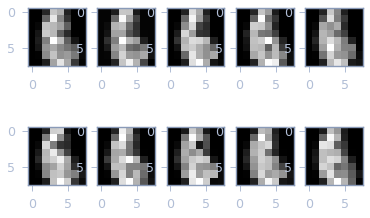

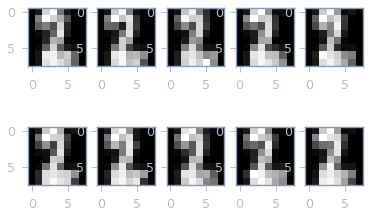

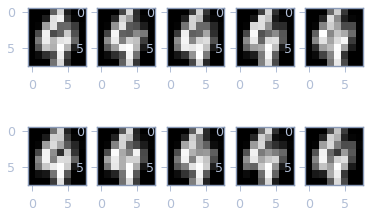

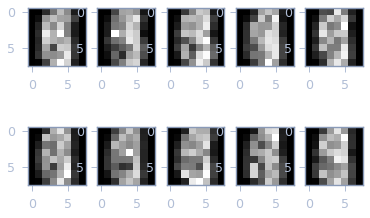

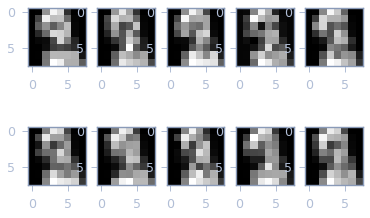

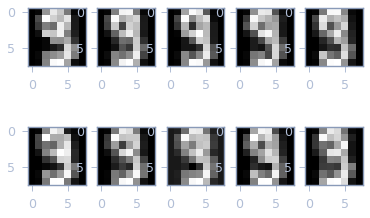

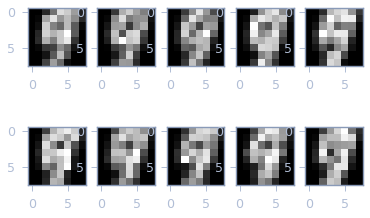

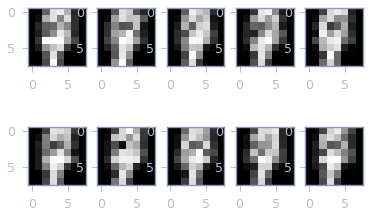

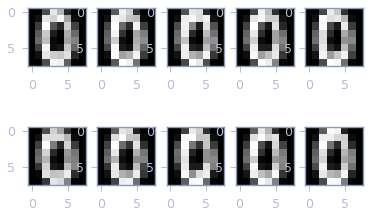

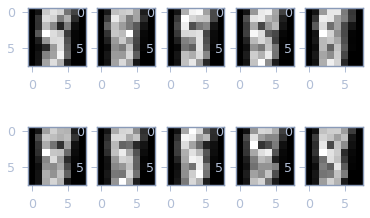

In [28]:
# Generating numbers using the learnt distributions
for i in range(10):
    for j in range(10):
        pixels = np.array([np.random.normal(t.means_[i][pixel], t.covariances_[i][pixel]) for pixel in range(64)])
        plt.subplot(2, 5, j + 1)
        plt.imshow(pixels.reshape(8,8), cmap=plt.cm.gray)
    plt.show()

In [29]:
gmm = GaussianMixture(10, covariance_type='diag', init_params='random')
gmm.fit(x_train)
print(gmm.converged_)

True


In [ ]:
# for i in range(10):
#     for j in range(10):
#         pixels = np.array([np.random.normal(gmm.means_[i][pixel], gmm.covariances_[i][pixel]) for pixel in range(64)])
#         plt.subplot(2, 5, j + 1)
#         plt.imshow(pixels.reshape(8,8), cmap=plt.cm.gray)
#     plt.show()

In [30]:
# (t.covariances_.sum(),np.array([np.diagonal(cov) for cov in gmm.covariances_]).sum()),(
# t.means_.sum(),gmm.means_.sum())
(t.covariances_.sum(),gmm.covariances_.sum()),(
t.means_.sum(),gmm.means_.sum())

((30.889969367882113, 27.054281697837798),
 (196.15306033920461, 192.25260110261905))

In [32]:
class GNB:
    def __init__(self, gmm):
        self.gmm = gmm
        
    def fit(self, k, x_train, y_train):
        self.k = k
        
        self.mean = self.gmm.means_
        self.var = self.gmm.covariances_
        self.w = np.log(self.gmm.weights_)
            
        
        self.create_target_mapping(x_train, y_train)
        
    # TODO: Could try to resolve ties in a way that minimizes duplicate labels
    def create_target_mapping(self, x_train, y_train):
        self.target_mapping = np.zeros(self.k)
        y_pred = self.predict(x_train, translate_targets=False)
        print(y_pred)
        for i in range(self.k):
            indexes = y_pred == i
            self.target_mapping[i] = mode(y_train[indexes])[0][0]
    
    def predict_single(self, x):
        f = lambda i: self.w[i] + multivariate_normal.logpdf(x, mean=self.mean[i], cov=self.var[i])
        
        return np.argmax(
            np.fromfunction(np.vectorize(f), shape=(self.k,), dtype=int)
        )
    
    def predict(self, x_test, translate_targets=True):
        y = np.apply_along_axis(self.predict_single, axis=1, arr=x_test)
        return self.target_mapping[y] if translate_targets else y

In [33]:
def print_metrics(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    targets = list(range(10))
    
    cm = confusion_matrix(y_test, y_pred, targets)
    cm_norm = cm / cm.sum(axis=1)
    
    cm_norm_df = pd.DataFrame(cm_norm, index=targets, columns=targets)
    
    plt.figure(figsize = (10,8))
    sns.set(font_scale=1.1)
    ax = sns.heatmap(
        cm_norm_df,
        annot=True,
        cmap="Blues",
    )

    font_styles = {'fontsize': 16, 'weight': 'bold'}

    ax.set_title('Confusion matrix', {**font_styles, 'fontsize': 25})
    ax.set_xlabel('Predicted', **font_styles)
    ax.set_ylabel('Actual', **font_styles)

    # matplotlib bug fix
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()
    
    print('accuracy', accuracy_score(y_test, y_pred))
    print('completeness_score', completeness_score(y_test, y_pred))
    print('homogeneity_score', homogeneity_score(y_test, y_pred))

[9 0 8 ... 4 3 9]


/home/kasper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       1.00      0.85      0.92        59
           1       0.19      0.14      0.16        49
           2       0.76      0.84      0.80        49
           3       0.45      0.73      0.56        64
           4       0.89      0.79      0.83        61
           5       0.46      0.62      0.53        47
           6       0.63      0.98      0.77        51
           7       0.55      0.95      0.69        57
           8       0.00      0.00      0.00        46
           9       0.00      0.00      0.00        57

    accuracy                           0.60       540
   macro avg       0.49      0.59      0.53       540
weighted avg       0.51      0.60      0.54       540



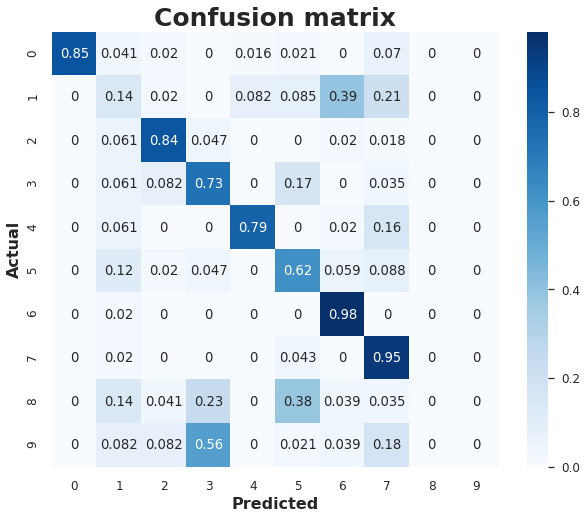

accuracy 0.6037037037037037
completeness_score 0.5865674538967516
homogeneity_score 0.5171547259472211


In [34]:
nb = GNB(t)
nb.fit(10, x_train, y_train)
y_pred = nb.predict(x_test)


print_metrics(y_test, y_pred)

[4 5 7 ... 4 4 0]


/home/kasper/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.98      0.92      0.95        59
           1       0.39      0.53      0.45        49
           2       0.40      0.41      0.40        49
           3       0.00      0.00      0.00        64
           4       0.80      0.85      0.83        61
           5       0.38      0.49      0.43        47
           6       0.96      0.96      0.96        51
           7       0.65      0.82      0.73        57
           8       0.00      0.00      0.00        46
           9       0.25      0.53      0.34        57

    accuracy                           0.56       540
   macro avg       0.48      0.55      0.51       540
weighted avg       0.49      0.56      0.51       540



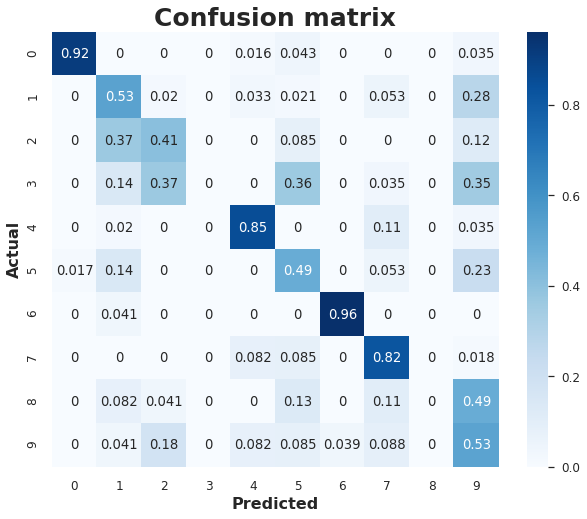

accuracy 0.5574074074074075
completeness_score 0.5413915675123767
homogeneity_score 0.4804581031983691


In [35]:
nb = GNB(gmm)
nb.fit(10, x_train, y_train)
y_pred = nb.predict(x_test)


print_metrics(y_test, y_pred)

[5 7 3 ... 1 6 0]
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        59
           1       0.76      0.63      0.69        49
           2       0.71      0.80      0.75        49
           3       0.89      0.78      0.83        64
           4       0.92      0.92      0.92        61
           5       0.95      0.81      0.87        47
           6       0.94      1.00      0.97        51
           7       0.86      0.95      0.90        57
           8       0.72      0.85      0.78        46
           9       0.71      0.79      0.75        57

    accuracy                           0.84       540
   macro avg       0.85      0.84      0.84       540
weighted avg       0.85      0.84      0.84       540



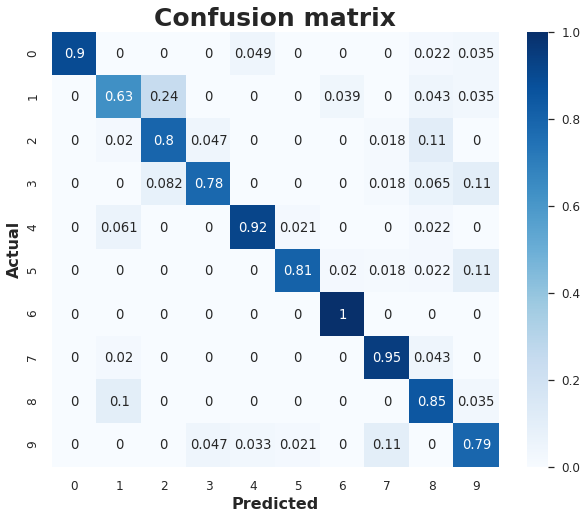

accuracy 0.8444444444444444
completeness_score 0.7589206257481226
homogeneity_score 0.7575384720025669


In [36]:
# This is cheating but achives the "needed" results
# These are the default values btw
gmm2 = GaussianMixture(10, covariance_type='full', init_params='kmeans')
gmm2.fit(x_train)
gmm2.covariances_ = np.array([np.diagonal(cov) for cov in gmm2.covariances_])


nb = GNB(gmm2)
nb.fit(10, x_train, y_train)
y_pred = nb.predict(x_test)


print_metrics(y_test, y_pred)